In [1]:
"""author: Vetivert? 💐 
created: 05/06/2025 @ 21:58:06"""

'author: Vetivert? 💐 \ncreated: 05/06/2025 @ 21:58:06'

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import pandas as pd 
import seaborn as sns 

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV 
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb

import sys
import os

current_dir = os.path.abspath('')

parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.utils.prefix_path import *
# from src.utils.models import *
from src.utils.functions import *

# FUNCTIONS

In [3]:
def distribution_plot(df_x, x_name: str, data_name:str):
    plt.subplots(figsize=(10, 6))
    x_3 = df_x.loc[df_x['Diagnosis'] == 3, x_name]
    x_2 = df_x.loc[df_x['Diagnosis'] == 2, x_name]
    x_1 = df_x.loc[df_x['Diagnosis'] == 1, x_name]
    y_3 = np.random.rand(x_3.shape[0])
    y_2 = np.random.rand(x_2.shape[0])
    y_1 = np.random.rand(x_1.shape[0])

    # fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))

    # ax[0].scatter(x_3, np.random.rand(x_3.shape[0]) * 10, color='red', alpha=0.75)
    # ax[0].scatter(x_2, np.random.rand(x_2.shape[0]) * 10, color='navy', alpha=0.75)
    # ax[0].scatter(x_1, np.random.rand(x_1.shape[0]) * 10, color='green', alpha=0.75)
    # ax[0].set_xlabel(x_name + ' Values')
    # ax[0].set_xlim(0, np.max(df_x[x_name]) + 1)
    # ax[0].set_ylim(-0.25, 10.25)
    # ax[0].set_yticks([])

    plt.scatter(x_3, [4/80] * (y_3 + 1), label = 'Diagnosis 3', color='red', alpha=0.65)
    plt.scatter(x_2, [2/80] * (y_2 + 1), label = 'Diagnosis 2',color='navy', alpha=0.65)
    plt.scatter(x_1, [1/80] * (y_1 + 1), label = 'Diagnosis 1',color='green', alpha=0.65)
    plt.vlines(np.max(x_3), 0, (4/80) * (y_3[np.argmax(x_3)]+1), label = f'{np.max(x_3)}: max value of Diagnosis 3', color='red', alpha=0.65, linestyle="--")
    plt.vlines(np.min(x_3), 0, (4/80) * (y_3[np.argmin(x_3)]+1), label = f'{np.min(x_3)}: min value of Diagnosis 3', color='red', alpha=0.65, linestyle=":")
    plt.vlines(np.max(x_2), 0, (2/80) * (y_2[np.argmax(x_2)]+1), label = f'{np.max(x_2)}: max value of Diagnosis 2', color='navy', alpha=0.65, linestyle="--")
    plt.vlines(np.min(x_2), 0, (2/80) * (y_2[np.argmin(x_2)]+1), label = f'{np.min(x_2)}: min value of Diagnosis 2', color='navy', alpha=0.65, linestyle=":")
    plt.vlines(np.max(x_1), 0, (1/80) * (y_1[np.argmax(x_1)]+1), label = f'{np.max(x_1)}: max value of Diagnosis 1', color='green', alpha=0.65, linestyle="--")
    plt.vlines(np.min(x_1), 0, (1/80) * (y_1[np.argmin(x_1)]+1), label = f'{np.min(x_1)}: min value of Diagnosis 1', color='green', alpha=0.65, linestyle=":")
    sns.kdeplot(x_3, color='red')
    sns.kdeplot(x_2, color='navy')
    sns.kdeplot(x_1, color='green')
    plt.legend()
    # plt.xlim(-10, np.max(df_x[x_name]) + 100)
    plt.yticks([])
    plt.title(x_name + ' Distribution by Diagnosis ' + data_name, fontsize=14)
    # plt.colorbar(ticks = [1,2,3], values = [1,2,3], label='Diagnosis')

    # fig.colorbar(cmap=['green','navy','red'], ticks = [1,2,3], values = [1,2,3], ax = ax[0], label='Diagnosis')
    # fig.suptitle(x_name + ' Distribution by Diagnosis', fontsize=16)
    plt.show()

# LOAD DATA 2017 + 2019

In [4]:
# Load dataset
df = pd.read_csv(FULL_DATA_PATH, sep=";", header=3) #separator is ;
# df = df.apply(pd.to_numeric, errors='coerce')

# Drop redundant cols + rows
df.drop(REDUNDANT_ROWS, inplace=True)

df.reset_index(drop=True, inplace=True) #reset index
df.drop(REDUNDANT_COLS, axis=1, inplace=True)

df.fillna(FILLNA_VALUES) #df[1] = df[1].fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(1) #addtional diseases
df = df.replace('8(nặng xin về)', 8)
df = df.replace('(17/9)3.7', 3.7)

for i in HEART_INDEX:
    df[i] = pd.to_numeric(df[i], errors='coerce')
    print(f"{i}: {df[str(i)].mean()}")
print("\nDiastolic BP < 80: Huyết áp tối ưu \nSystolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp")

# df.drop(HEART_INDEX, axis=1, inplace=True)

uniques, counts = np.unique(df['Diagnosis'], return_counts=True)
print('\nDiagnosis\'s classes: ',dict(zip(uniques, np.round(counts * 100 / len(df['Diagnosis']), 2))))
df['Diagnosis'] = np.where(df['Diagnosis'] == '3', '2', df['Diagnosis'])
df['Day of illness'] = np.where(df['Day of illness'] == '55', '5', df['Day of illness'])
df['Systolic BP'] = np.where(df['Systolic BP'] == 1120, 120, df['Systolic BP'])



# hematoma group
hema = df[HEMATOMA_COLS]
hema = hema.assign(stacked=hema.astype(str).agg(''.join, axis=1))
hema['stacked'] = (pd.to_numeric(hema['stacked'], errors='coerce'))
hema['stacked_int'] = np.where(hema['stacked'] == 0, 0, 1)
# Get the integer position of the first hematoma column
hematoma_idx = df.columns.get_indexer([HEMATOMA_COLS[0]])[0]
#hematoma_idx.item() -> extract the value from np.int64 into native Python int
df.insert(hematoma_idx.item(), 'hematoma', hema['stacked_int']) #get col index by its name
df.drop(HEMATOMA_COLS, axis=1, inplace=True)

# bleeding group
bleed = df[BLEEDING_COLS]
bleed = bleed.assign(stacked=bleed.astype(str).agg(''.join, axis=1))
bleed['stacked'] = (pd.to_numeric(bleed['stacked'], errors='coerce'))
bleed['stacked_int'] = np.where(bleed['stacked'] == 0, 0, 1)
# Get the integer position of the first bleeding column
bleeding_idx = df.columns.get_indexer([BLEEDING_COLS[0]])[0]
df.insert(bleeding_idx.item(), 'Mucosa membrane bleeding', bleed['stacked_int'])
df.drop(BLEEDING_COLS, axis=1, inplace=True)

# additional diseases group
add_diseases = df[ADDITIONAL_DISEASES]
add_diseases = add_diseases.assign(stacked=add_diseases.astype(str).agg(''.join, axis=1))
add_diseases['stacked'] = (pd.to_numeric(add_diseases['stacked'], errors='coerce'))
add_diseases['stacked_int'] = np.where(add_diseases['stacked'] == 0, 0, 1)
# Get the integer position of the first additional diseases column
additional_diseases_idx = df.columns.get_indexer([ADDITIONAL_DISEASES[0]])[0]
df.insert(additional_diseases_idx.item(), 'additional_diseases', add_diseases['stacked_int'])
# df.insert(df.columns.get_loc(ADDITIONAL_DISEASES[0]), 'additional_diseases', add_diseases['stacked_int'])
df.drop(ADDITIONAL_DISEASES, axis=1, inplace=True)

# df = df.copy()


Pulse rate: 89.60148514851485
Systolic BP: 117.25
Diastolic BP: 70.63861386138613

Diastolic BP < 80: Huyết áp tối ưu 
Systolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp

Diagnosis's classes:  {'1': np.float64(56.4), '2': np.float64(39.66), '3': np.float64(3.94)}


/tmp/ipykernel_7508/1674654194.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('8(nặng xin về)', 8)
/tmp/ipykernel_7508/1674654194.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(hematoma_idx.item(), 'hematoma', hema['stacked_int']) #get col index by its name
/tmp/ipykernel_7508/1674654194.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

In [40]:
df_PLT = df.loc[:, 'WBC1':'MPV 9'].copy()
df_PLT = df_PLT.drop(['MPV 1','MPV 2','MPV 3','MPV 4', 'MPV 5', 'MPV 6', 'MPV 7', 'MPV 8', 'MPV 9'], axis=1)
df_PLT = df_PLT.replace('(17/9)3.7', 3.7)
df_PLT = df_PLT.replace('(28/6)4.1', 4.1)
df_PLT = df_PLT.replace('(27/11)5.5', 5.5)
df_PLT = df_PLT.replace(' ', np.nan)
# x1_features = df_PLT.columns
for i in df_PLT.columns:
    df_PLT[i] = df_PLT[i].str.replace(',', '.', regex=False).astype(float)
df_PLT.reset_index(drop=True, inplace=True) #reset index
df_PLT.fillna(0, inplace=True) #fill NaN with 0
df_PLT = df_PLT.to_numpy()

# print(df_PLT.shape)
PLT_list = []
PLT_arr = []
for i in range(df_PLT.shape[0]):
    # Extract non-zero elements
    non_zero_elements = df_PLT[i][np.nonzero(df_PLT[i])]
    PLT_list.append(non_zero_elements)
    PLT_arr.append(PLT_list[i][:7])
PLT_arr = np.array(PLT_arr)
print("PLT_arr:", PLT_arr.shape)

df_AST = df.loc[:, 'Glu1':'GGT9'].copy()
df_AST = df_AST.drop(['Bil TP7','Bil TT 7'], axis=1)
df_AST = df_AST.replace('(', np.nan)
df_AST = df_AST.replace('(18/6)7.2', 7.2)
df_AST = df_AST.replace('(8/6)9', 9)
df_AST = df_AST.replace("(11/7)", np.nan)
df_AST = df_AST.replace("(4/12)", np.nan)
df_AST = df_AST.replace(' ', np.nan)
for j in df_AST.columns:
    df_AST[j] = df_AST[j].str.replace(',', '.', regex=False).astype(float)
df_AST.reset_index(drop=True, inplace=True) #reset index
df_AST.fillna(0, inplace=True) #fill NaN with 0
df_AST = df_AST.to_numpy()

AST_list = []
AST_arr = []

max_len = 7
for i in range(df_AST.shape[0]):
    # Extract non-zero elements
    non_zero_elements = df_AST[i][np.nonzero(df_AST[i])]
    # Pad or truncate to fixed length
    if len(non_zero_elements) >= max_len:
        AST_arr.append(non_zero_elements[:max_len])  # Truncate if too long
    else:
        # Pad with zeros if too short
        padded = np.zeros(max_len)
        padded[:len(non_zero_elements)] = non_zero_elements
        AST_arr.append(padded)

AST_arr = np.array(AST_arr)
# print(AST_arr.shape)
print(f"AST_arr: {AST_arr.shape}")

PLT_column_names = ['WBC1','N1','L1','RBC1','Hb1','HCT1','PLT1']
AST_column_names = ['Glu1','Ure1','Cre1','Alb1','AST1','ALT1','GGT1']

df_symptoms = df.loc[:, 'Diagnosis':'Oliguria'].copy()

for i, col_name in enumerate(PLT_column_names):
    df_symptoms[col_name] = PLT_arr[:, i]
for i, col_name in enumerate(AST_column_names):
    df_symptoms[col_name] = AST_arr[:, i]

# df_symptoms

PLT_arr: (406, 7)
AST_arr: (406, 7)


In [41]:
# df_symptoms.columns
df_symptoms = df_symptoms[~((df_symptoms['AST1'] == 0) & (df_symptoms['ALT1'] == 0))]

df_symptoms

,Diagnosis,Gende,DHF infection His.,additional_diseases,Fever,Bleeding,Fatigue,Day of illness,Level of temp,Duration fever,...,Hb1,HCT1,PLT1,Glu1,Ure1,Cre1,Alb1,AST1,ALT1,GGT1
3,2,1,0,1,1,1,0,5,NaN,NaN,...,158.0,0.461,59.0,3.16,3.30,88.0,292.40,240.2,22.5,224.1
4,1,1,0,1,1,0,1,4,NaN,NaN,...,126.0,0.470,67.0,5.30,4.30,95.0,63.30,32.0,0.0,0.0
5,1,0,0,1,1,0,1,3,3,6,...,136.0,0.392,146.0,7.30,2.10,78.0,41.00,75.2,46.8,49.7
6,2,0,0,0,1,1,0,4,NaN,NaN,...,128.0,0.375,156.0,7.29,3.30,86.0,37.30,70.7,37.5,18.3
7,2,0,0,1,1,0,0,3,NaN,NaN,...,124.0,0.353,63.0,7.71,3.70,77.0,35.10,51.9,41.0,52.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,2,0,0,1,1,1,1,4,2,6,...,129.0,0.370,74.0,6.80,3.00,64.0,54.00,26.0,0.0,0.0
402,2,0,0,1,1,0,1,5,3,6,...,136.0,0.410,55.0,6.30,2.20,70.0,67.00,65.0,0.0,0.0
403,1,1,0,0,1,0,1,6,3,7,...,147.0,0.470,65.0,78.00,23.00,24.0,5.09,3.9,86.0,40.0
404,2,1,0,1,1,0,1,7,3,7,...,158.0,0.440,7.0,7.90,5.80,93.0,82.00,43.0,80.0,0.0


In [42]:
df_symptoms.columns

Index(['Diagnosis', 'Gende', 'DHF infection His.', 'additional_diseases',
       'Fever', 'Bleeding', 'Fatigue', 'Day of illness', 'Level of temp',
       'Duration fever', 'Pulse rate', 'Systolic BP', 'Diastolic BP',
       'Headache', 'Body ache', 'Rash', 'hematoma', 'Mucosa membrane bleeding',
       'Pleural effusion', 'Ascites', 'Pericardial effusion', 'Vomiting',
       'Abdominal pain or tendness', 'Liver enlargement', 'Oliguria', 'WBC1',
       'N1', 'L1', 'RBC1', 'Hb1', 'HCT1', 'PLT1', 'Glu1', 'Ure1', 'Cre1',
       'Alb1', 'AST1', 'ALT1', 'GGT1'],
      dtype='object')

# LOAD DATA 2025

In [147]:
df_2025 = pd.read_csv(DATA_PATH_2025, sep=",", header=0, nrows = 125) #separator is ;

In [18]:
# df_2025.dtypes
df_2025

,STT,Số bệnh án,Họ & tên,Năm sinh,Tuổi,Giới tính,Chẩn đoán,Cân nặng,Chiều cao,BMI,...,CRE,BILI-TP,BILI-TT,ALBUMUN,Glucose,MaBenhpham,IgG,IgM,KN B19,NestedPCR
0,1,22043345,Võ Minh Trọng,2003,19,1,Sốt xuất huyết Dengue N3 có DHCB/ Rối loạn điệ...,57.0,168.0,20.195578,...,80.7,7.9,2.4,34.1,NaN,DEN1,0,0,0,0
1,2,22042989,Trương Văn Đức,1999,23,1,Sốt xuất huyết Dengue/ Viêm loét dạ dày- tá tr...,90.0,167.0,32.270788,...,84.7,8.2,1.9,NaN,6.0,DEN2,0,0,0,0
2,3,22043439,Tăng Thế Anh Hoàng,2002,20,1,Sốt xuất huyết Dengue/ Viêm gan nhiễm độc/ viê...,70.0,170.0,24.221453,...,NaN,NaN,NaN,NaN,NaN,DEN3,0,0,0,0
3,4,22042233,Đặng Thái Phong,1999,23,1,Sốt nhiễm khuẩn/ Nhiễm khuẩn huyết đường vào t...,53.0,174.0,17.505615,...,124.6,22.5,10.4,NaN,5.4,DEN4,0,0,0,0
4,5,22043566,Phạm Mạnh Cường,1984,38,1,Sốt xuất huyết Dengue có DHCB/ Viêm dạ dày - t...,60.0,170.0,20.761246,...,130.5,19.2,4.2,NaN,NaN,DEN5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,121,22058520,Phan Thị Phượng,1985,37,2,Sốt xuất huyết Dengue có DHCB/Tăng men gan,54.0,155.0,22.476587,...,NaN,NaN,NaN,NaN,NaN,DEN121,1,0,0,0
121,122,22058492,Lê Thị Danh,1984,38,2,Sốt xuất huyết Dengue có DHCB,46.0,153.0,19.650562,...,77.2,7.4,2.0,30.9,6.6,DEN122,0,0,0,0
122,123,22058741,Nguyễn Thị Thu,1975,47,2,Sốt xuất huyết Dengue/ Viêm gan nhiễm độc/ rối...,NaN,NaN,NaN,...,78.8,12.1,3.5,32.3,4.3,DEN123,0,0,0,0
123,124,22058461,Nguyễn Thị Hạnh,1971,51,2,Sốt siêu vi/viêm loét DD-TT/ trào ngược dạ dày...,50.0,150.0,22.222222,...,69.9,6.1,0.8,36.4,9.6,DEN124,0,0,0,0


In [74]:
df_test = df_2025.loc[:, 'Mạch':'ALT'].copy()

In [75]:
df_test

,Mạch,THA,HATT,HATTr,WBC,NEU,%NEU,LYM,%LYM,RBC,HGB,HCT,PLT,AST,ALT
0,98.0,0,118.0,73.0,2.9,2.1,72.0,0.5,16.8,5.17,15.2,43.9,76,120.5,45.9
1,114.0,0,120.0,70.0,2.2,1.1,49.0,0.6,26.7,5.29,15.2,44.9,62,401.1,263.3
2,104.0,0,112.0,76.0,4.6,3.8,82.4,0.2,4.7,4.41,13.2,39.3,144,16.8,15.5
3,108.0,0,88.0,56.0,6.8,6.3,93.5,0.2,2.8,4.22,12.6,38.1,118,48.9,29.7
4,80.0,0,120.0,70.0,6.6,1.3,19.2,2.1,32.1,5.31,15.9,46.9,14,66.2,10.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,89.0,0,100.0,60.0,3.3,1.1,32.8,1.4,42.3,4.95,14.0,42.3,27,NaN,NaN
121,80.0,0,110.0,70.0,3.6,1.7,46.9,1.0,27.7,5.85,16.3,49.6,8,78.5,41.3
122,NaN,0,NaN,NaN,3.1,1.7,54.5,0.6,26.1,4.34,12.9,38.4,28,214.4,125.2
123,89.0,0,101.0,70.0,3.5,1.6,45.6,1.5,43.1,4.14,11.7,35.4,161,23.8,24.9


# LOAD DATA SAMPLES

In [47]:
df_samples = pd.read_csv(DATA_PATH_SAMPLES, sep=",", header=0, nrows = 279) #separator is ;

df_samples.drop(['Oder No', 'Age', 'Samp No', 'Fiver', 'bleeding place','NS1','IgG','IgM'], inplace=True, axis=1)
df_samples = df_samples.replace('110,0', 111.0)
df_samples['Vomiting'] = df_samples['Vomiting'].fillna(0)
df_samples["PLT"] = pd.to_numeric(df_samples["PLT"])

df_samples = df_samples.dropna() #remove NA elements in AST/ALT



In [57]:
# df_samples
df_samples.dtypes

# df_samples.isnull().sum()


Gende               int64
Diagnosis           int64
day of symtoms      int64
GOT               float64
GPT               float64
RBC               float64
WBC               float64
PLT               float64
HCT               float64
NS1               float64
IgG               float64
IgM               float64
bleeding            int64
Vomiting          float64
headache            int64
bodyache            int64
dtype: object

In [60]:
# Sample data
X = df_samples.drop(columns=['Diagnosis']).values
Y = df_samples['Diagnosis'].values.ravel()

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

rf_model = RandomForestClassifier()

accuracies = []

# Stratified K-Fold loop
for train_index, val_index in skf.split(X, Y):
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    rf_model.fit(X_train, Y_train)
    preds = rf_model.predict(X_val)
    acc = accuracy_score(Y_val, preds)
    accuracies.append(acc)

print(f"Cross-validated accuracy scores: {accuracies}")
print(f"Mean accuracy: {np.mean(accuracies):.4f}")

/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


Cross-validated accuracy scores: [0.75, 0.875, 0.625, 0.7916666666666666, 0.625, 0.7916666666666666, 0.6666666666666666, 0.7083333333333334, 0.7083333333333334, 0.782608695652174]
Mean accuracy: 0.7324


In [61]:
param_grid = {'n_estimators': [50, 75, 100, 200], 'max_depth': [3, 7, 9, 15], 'min_samples_split': [2, 5, 10, 12 ], 'min_samples_leaf': [1, 2, 4,6,8], 'max_features': ['sqrt', 'log2']}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=StratifiedKFold(n_splits=10), scoring='accuracy')
grid.fit(X, Y)

print(grid.best_params_)
print(grid.best_score_)

/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
0.7661231884057972


In [73]:
import joblib

# Save the model
joblib.dump(grid.best_estimator_, 'RF_2025_076.pkl')

['RF_2025_076.pkl']

Index(['Gende', 'day of symtoms', 'GOT', 'GPT', 'RBC', 'WBC', 'PLT', 'HCT',
       'NS1', 'IgG', 'IgM', 'bleeding', 'Vomiting', 'headache', 'bodyache'],
      dtype='object')


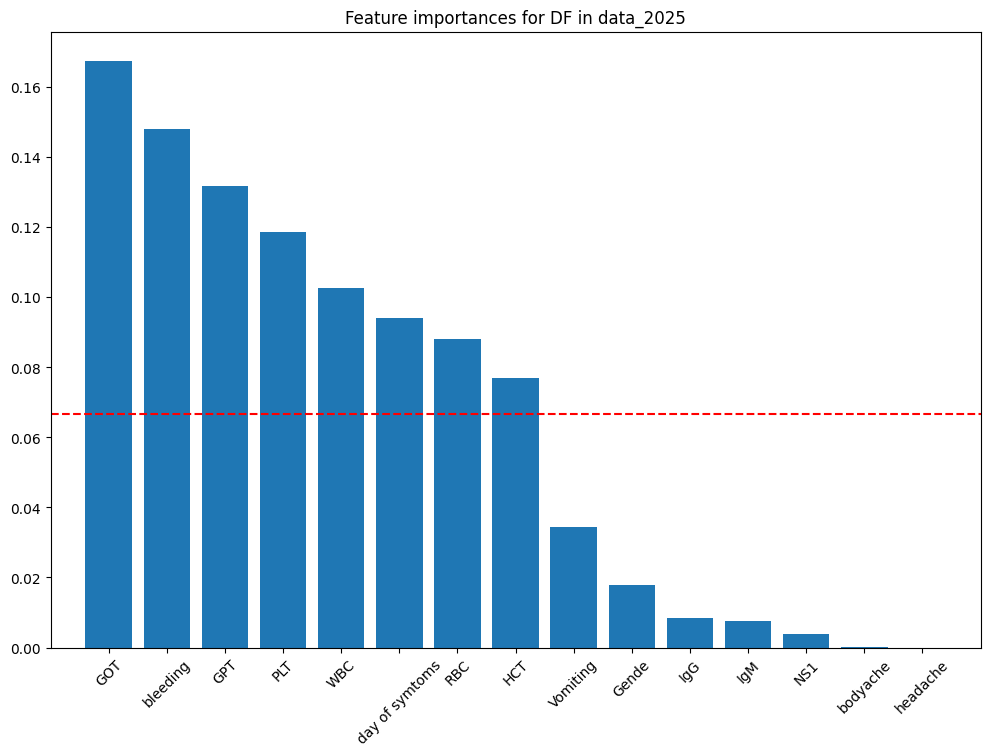

In [69]:
# Classification report
# print("\nClassification Report:")
# print(classification_report(YA_test, YA_pred))

# uniques, counts = np.unique(YA_pred, return_counts=True)
# print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(YA_pred), 2))))

# Plotting feature importances
features = df_samples.drop(columns=['Diagnosis']).columns
print(features)
importances = grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature importances for DF in data_2025")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

In [76]:

x1_train, x1_test, y1_train, y1_test = train_test_split(X, Y, \
                                                    test_size=0.2, random_state=17, stratify=Y)
x1_features = df_samples.drop(columns=['Diagnosis']).columns

# x1_train, x1_test, y1_train, y1_test = x1_train.to_numpy(), x1_test.to_numpy(), y1_train.to_numpy(), y1_test.to_numpy()

print('x1_train shape: ', x1_train.shape, 'y1_train shape: ',  y1_train.shape)
print('x1_test shape: ', x1_test.shape, 'y1_test shape: ',  y1_test.shape)
uniques, counts = np.unique(y1_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y1_test), 2))))

x1_train shape:  (191, 15) y1_train shape:  (191,)
x1_test shape:  (48, 15) y1_test shape:  (48,)
percentage of classes:  {np.int64(1): np.float64(62.5), np.int64(2): np.float64(35.42), np.int64(3): np.float64(2.08)}


In [80]:
# Convert class labels from 1-based (1,2,3) to 0-based (0,1,2) for XGBoost
y1_train_0based = y1_train - 1
y1_test_0based = y1_test - 1

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    eval_metric='error'
)

xgb_model.fit(x1_train, y1_train_0based)

# When predicting later, remember to add +1 to convert back to original classes

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

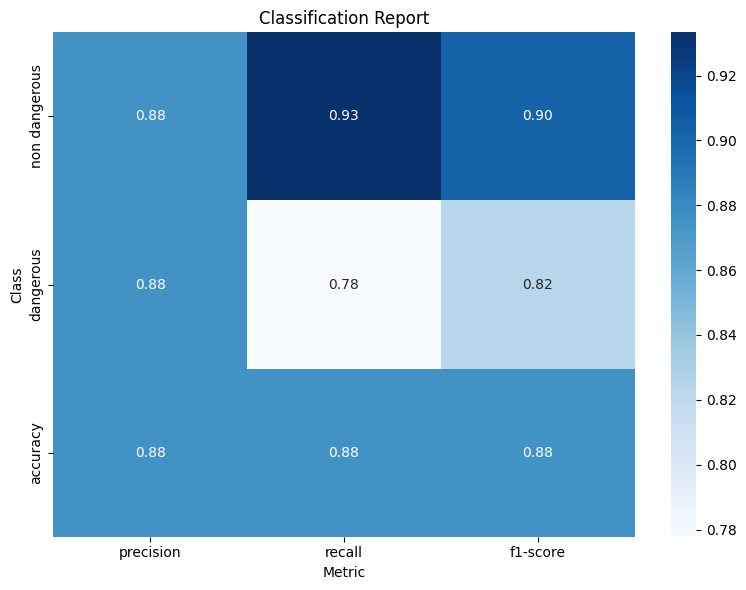

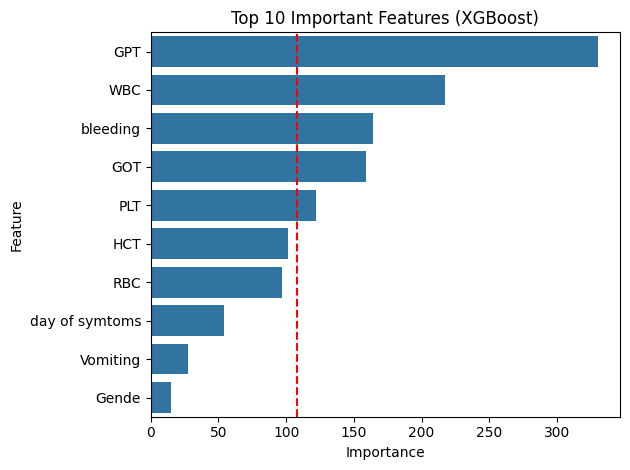

In [82]:
evaluate(xgb_model, x1_test, y1_test_0based)
gain_importances_df = plot_feature_importance(xgb_model, x1_features, importance_type='total_gain')

In [83]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.001, 0.01, 0.1, 0.2]
}

# search = RandomizedSearchCV(xgb.XGBClassifier(), param_grid, cv=StratifiedKFold(n_splits=10), scoring='accuracy', verbose=1)
search = GridSearchCV(xgb_model, param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
search.fit(x1_train, y1_train_0based)
print("Best parameters:", search.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}


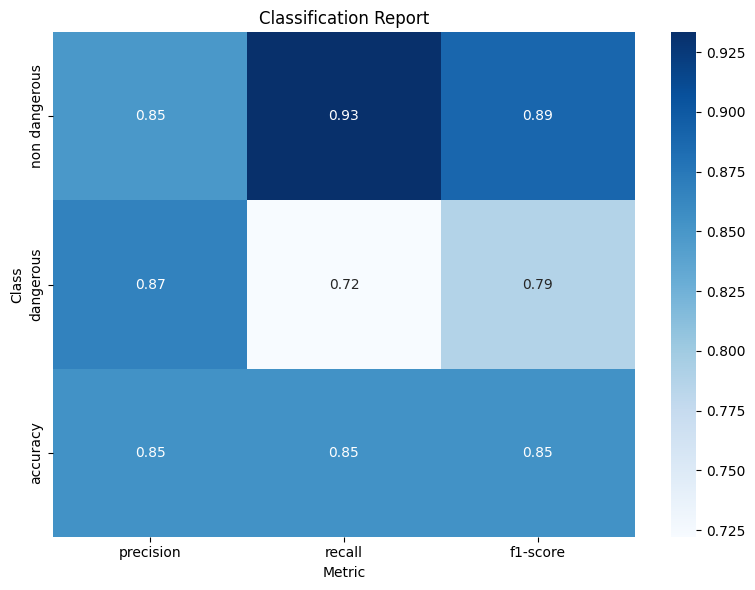

{'accuracy': 0.8541666666666666,
 'precision': 0.8666666666666667,
 'recall': 0.7222222222222222,
 'f1_score': 0.7878787878787878,
 'roc_auc': np.float64(0.8444444444444444)}

In [84]:
xgb_grid = search.best_estimator_
evaluate(xgb_grid, x1_test, y1_test_0based)

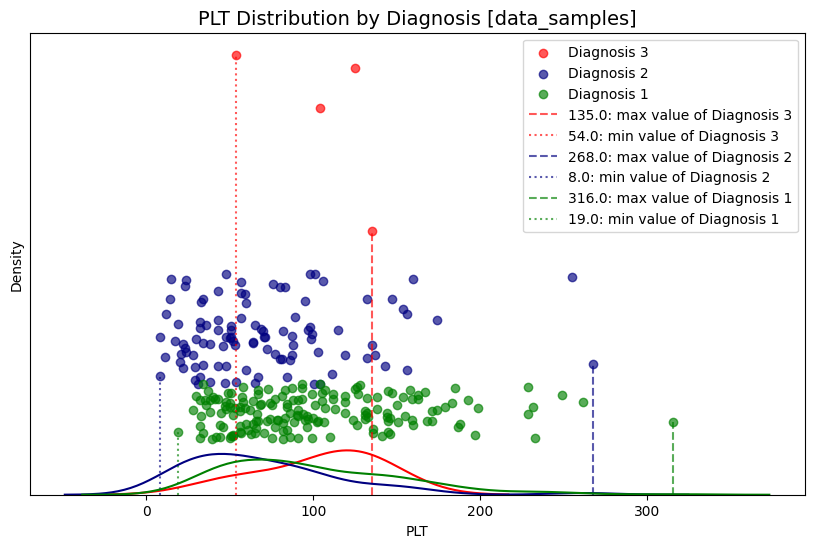

In [34]:
distribution_plot(df_samples, 'PLT', data_name = '[data_samples]')

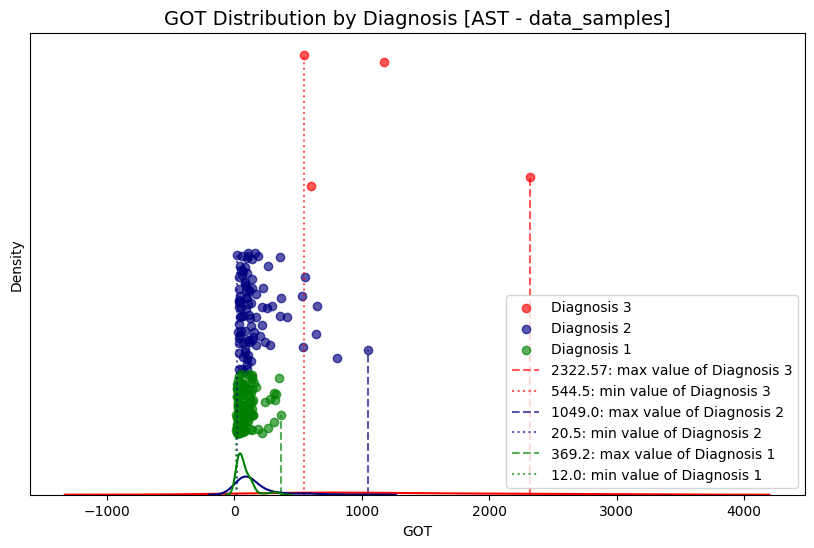

In [35]:
distribution_plot(df_samples, 'GOT', data_name = '[AST - data_samples]')

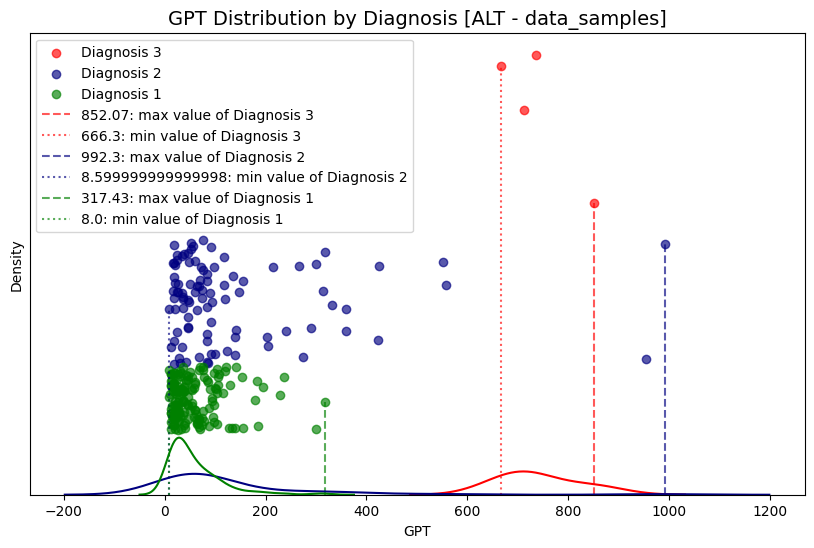

In [36]:
distribution_plot(df_samples, 'GPT', data_name = '[ALT - data_samples]')

In [42]:
df_samples

,Gende,Diagnosis,day of symtoms,GOT,GPT,RBC,WBC,PLT,HCT,NS1,IgG,IgM,bleeding,bleeding place,Vomiting,headache,bodyache
0,1,2,5,292.4,240.2,4.890,1.39,46.00,0.440,1.0,1.0,1.0,1,2,0.0,1,1
1,0,1,4,68.4,97.3,4.250,2.40,79.00,0.371,1.0,0.0,0.0,0,0,0.0,1,1
4,0,2,6,20.5,12.3,4.944,4.20,38.01,0.440,1.0,0.0,0.0,1,2,0.0,1,1
6,1,1,5,63.3,32.0,4.900,4.10,67.00,0.470,1.0,0.0,0.0,0,0,0.0,1,1
7,0,1,3,75.2,46.8,4.590,2.44,146.00,0.392,1.0,0.0,0.0,0,0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,0,1,5,123.9,57.5,4.608,2.99,34.85,0.400,1.0,0.0,0.0,0,0,0.0,1,1
275,1,1,2,22.6,14.6,4.300,3.65,138.00,0.382,1.0,0.0,0.0,0,0,0.0,1,1
276,0,1,5,77.5,59.9,3.390,3.08,141.00,0.293,1.0,0.0,0.0,0,0,0.0,1,1
277,0,1,6,129.8,75.9,4.430,2.90,61.00,0.365,1.0,0.0,0.0,0,0,0.0,1,1


# CASE 1: Data 2017/2019 + Data_samples (with symptoms)

In [151]:
features = ['Gende','Diagnosis','Day of illness','AST1','ALT1','RBC1','WBC1','PLT1','HCT1','Bleeding','Vomiting','Headache','Body ache']
df_case1 = df_symptoms[features].copy()

df_samples = df_samples.rename(columns={
    'day of symtoms': 'Day of illness',
    'GOT': 'AST1',
    'GPT': 'ALT1',
    'RBC': 'RBC1',
    'WBC': 'WBC1',
    'PLT': 'PLT1',
    'HCT': 'HCT1',
    'bleeding': 'Bleeding',
    'headache': 'Headache',
    'bodyache': 'Body ache',
})

df_case1 = pd.concat([df_case1, df_samples], axis=0, ignore_index=True)
df_case1['Diagnosis'] = np.where(df_case1['Diagnosis'] == '3', '2', df_case1['Diagnosis'])
df_case1['Diagnosis'] = np.where(df_case1['Diagnosis'] == 3, '2', df_case1['Diagnosis'])

df_case1

,Gende,Diagnosis,Day of illness,AST1,ALT1,RBC1,WBC1,PLT1,HCT1,Bleeding,Vomiting,Headache,Body ache
0,1,2,5,240.2,22.5,5.040,1.45,59.00,0.461,1,0,1,1
1,1,1,4,32.0,0.0,4.900,4.10,67.00,0.470,0,0,1,1
2,0,1,3,75.2,46.8,4.590,2.44,146.00,0.392,0,1,1,1
3,0,2,4,70.7,37.5,3.940,4.50,156.00,0.375,1,1,1,1
4,0,2,3,51.9,41.0,3.880,2.32,63.00,0.353,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,0,1,5,123.9,57.5,4.608,2.99,34.85,0.400,0,0.0,1,1
591,1,1,2,22.6,14.6,4.300,3.65,138.00,0.382,0,0.0,1,1
592,0,1,5,77.5,59.9,3.390,3.08,141.00,0.293,0,0.0,1,1
593,0,1,6,129.8,75.9,4.430,2.90,61.00,0.365,0,0.0,1,1


### RF - df_Case_1

In [ ]:
diag_symptoms = df_case1['Diagnosis']
df_case1.drop(columns=['Diagnosis'], inplace=True)


In [113]:
X = df_case1.values
Y = diag_symptoms.values.ravel()

X = X.astype(float)
Y = Y.astype(int)
print(X.dtype)
print(Y.dtype)

uniques, counts = np.unique(Y, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(Y), 2))))

float64
int64
percentage of classes:  {np.int64(1): np.float64(58.32), np.int64(2): np.float64(41.68)}


In [107]:
# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

rf_model = RandomForestClassifier()

accuracies = []

# Stratified K-Fold loop
for train_index, val_index in skf.split(X, Y):
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    rf_model.fit(X_train, Y_train)
    preds = rf_model.predict(X_val)
    acc = accuracy_score(Y_val, preds)
    accuracies.append(acc)

print(f"Cross-validated accuracy scores: {accuracies}")
print(f"Mean accuracy: {np.mean(accuracies):.4f}")

Cross-validated accuracy scores: [0.8166666666666667, 0.7833333333333333, 0.75, 0.75, 0.8666666666666667, 0.7796610169491526, 0.711864406779661, 0.7457627118644068, 0.8813559322033898, 0.7288135593220338]
Mean accuracy: 0.7814


In [92]:
param_grid = {'n_estimators': [50, 75, 100, 200], 'max_depth': [3, 7, 9, 15], 'min_samples_split': [2, 5, 10, 12 ], 'min_samples_leaf': [1, 2, 4,6,8], 'max_features': ['sqrt', 'log2']}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=StratifiedKFold(n_splits=10), scoring='accuracy')
grid.fit(X, Y)

print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
0.7916101694915255


In [106]:
print(X.shape, Y.shape)

(595, 12) (595,)


### XGB

In [114]:
Y = Y - 1

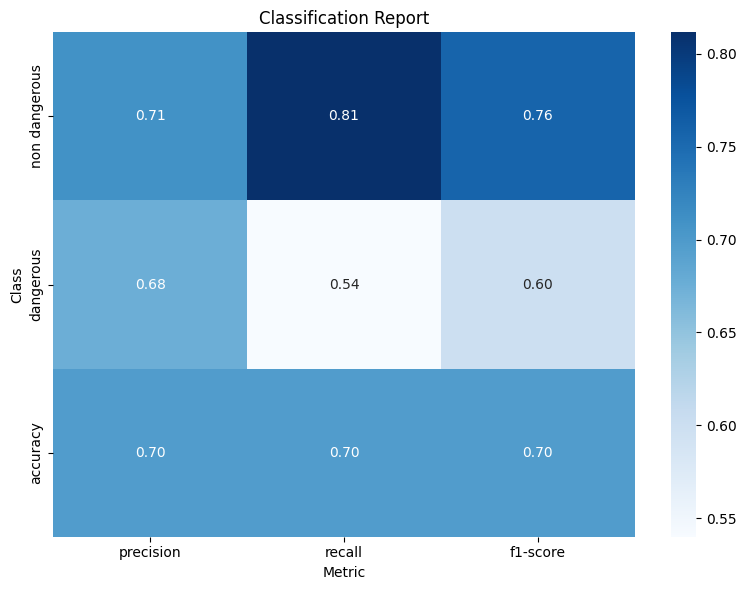

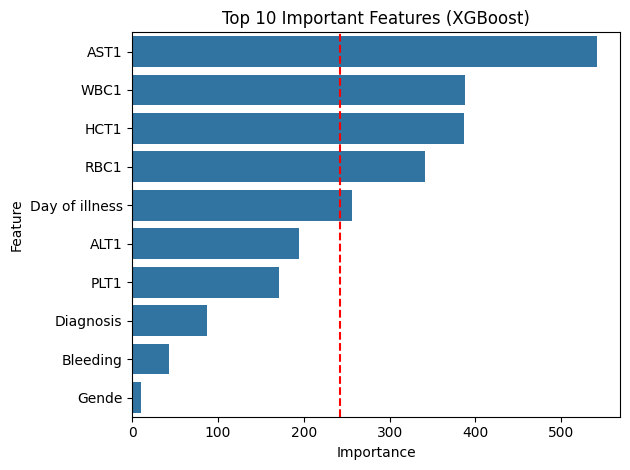

In [116]:

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=17, stratify=Y)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    # use_label_encoder=False,
    eval_metric='error'
)

xgb_model.fit(x_train, y_train)
evaluate(xgb_model, x_test, y_test)
gain_importances_df = plot_feature_importance(xgb_model, features, importance_type='total_gain')

### LightGBM

In [118]:
import lightgbm as lgb

In [119]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4, 5, -1],  # -1 means no limit
    'min_child_samples': [5, 10, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

random_search = RandomizedSearchCV(
    lgb.LGBMClassifier(random_state=42, verbose=-1), # type: ignore
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1_weighted',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit random search
random_search.fit(x_train, y_train)

/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/utils/v

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42, verbose=-1),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [2, 3, 4, 5, -1],
                                        'min_child_samples': [5, 10, 20, 50],
                                        'n_estimators': [50, 100, 200],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0, 0.1, 0.5, 1],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1_weighted')

In [120]:
# Get best parameters
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Train final model with best parameters
best_lgb_model = lgb.LGBMClassifier(**random_search.best_params_, random_state=42)
best_lgb_model.fit(x_train, y_train)

Best Parameters: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 50, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best Score: 0.7948162042043048


LGBMClassifier(colsample_bytree=0.8, min_child_samples=10, n_estimators=50,
               random_state=42, reg_alpha=1, reg_lambda=0.1)

### LSTM

In [122]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential, Model # type: ignore
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, SpatialDropout1D, Layer, BatchNormalization # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore
import tensorflow.keras.backend as K # type: ignore

2025-06-10 02:21:09.860969: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-10 02:21:09.948546: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-10 02:21:10.005389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749514870.070590    7508 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749514870.090559    7508 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749514870.219741    7508 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [121]:
def prepare_data_for_lstm(X, y):
    """Prepare data for LSTM model with attention"""
    # Scale features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Convert target to binary format
    # y_binary = (y == '2').astype(int)  # Assuming class '2' is the positive class
    
    # Reshape input to 3D format expected by LSTM: [samples, timesteps, features]
    # For this model, we use the entire feature vector as a single timestep sequence
    X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
    
    return X_reshaped, y, scaler

def prepare_sequence_data(X, y, n_steps=3):
    """
    Prepare data by splitting features into groups that are treated as timesteps
    This allows the attention mechanism to focus on different feature groups
    
    Args:
        X: Feature DataFrame
        y: Target values
        n_steps: Number of timesteps to divide features into
    """
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Convert target to binary format
    # y_binary = (y == '2').astype(int)
    
    # Calculate features per timestep
    n_features = X_scaled.shape[1]
    n_features_per_step = n_features // n_steps
    
    # Reshape into [samples, timesteps, features_per_step]
    X_reshaped = np.zeros((X_scaled.shape[0], n_steps, n_features_per_step))
    
    for i in range(n_steps):
        start_idx = i * n_features_per_step
        end_idx = start_idx + n_features_per_step if i < n_steps - 1 else n_features
        step_features = X_scaled[:, start_idx:end_idx]
        
        # Handle the last step which might have different number of features
        if step_features.shape[1] < n_features_per_step:
            # Pad with zeros if needed
            padding = np.zeros((X_scaled.shape[0], n_features_per_step - step_features.shape[1]))
            step_features = np.column_stack((step_features, padding))
            
        X_reshaped[:, i, :] = step_features
    
    return X_reshaped, y, scaler

In [128]:
# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.attention_weights = None

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. [batch_size, seq_len, 1]
        e = K.tanh(K.dot(x, self.W) + self.b)
        
        # Remove dimension of size 1. [batch_size, seq_len]
        e = K.squeeze(e, axis=-1)
        
        # Compute the weights. [batch_size, seq_len]
        alpha = K.softmax(e)
        
        # Reshape to [batch_size, seq_len, 1]
        alpha = K.expand_dims(alpha, axis=-1)
        
        # Compute the context vector. [batch_size, features]
        context = x * alpha
        context = K.sum(context, axis=1)
        
        return context 
    
class middleAttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(middleAttentionLayer, self).__init__(**kwargs)
        self.attention_weights = None

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(middleAttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. [batch_size, seq_len, 1]
        e = K.tanh(K.dot(x, self.W) + self.b)
        
        # # Remove dimension of size 1. [batch_size, seq_len]
        # e = K.squeeze(e, axis=-1)

        # # Compute the weights. [batch_size, seq_len]
        # alpha = K.softmax(e)
        
        # # Reshape to [batch_size, seq_len, 1]
        # alpha = K.expand_dims(alpha, axis=-1)
        
        self.attention_weights = K.softmax(e, axis=-1)

        # Compute the context vector. [batch_size, features]
        context = x * self.attention_weights
   
        return context  

def create_lstm_with_attention(input_shape, dropout_rate=0.2):
    """
    Create an LSTM model with Spatial Dropout and Attention for binary classification
    
    Args:
        input_shape: Tuple (timesteps, features) specifying input dimensions
        dropout_rate: Dropout rate to prevent overfitting
    
    Returns:
        Compiled Keras LSTM model with attention
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Spatial Dropout layer
    # This helps with overfitting by dropping entire feature maps
    x = BatchNormalization()(inputs)
    # print("x shape after BatchNormalization:", x.shape)  # Debugging line to check input shape
    # LSTM layer
    x = LSTM(12, return_sequences=True)(x)
    x = SpatialDropout1D(dropout_rate)(x)
    
    # Attention layer
    x = middleAttentionLayer()(x)

    x = LSTM(12, return_sequences=True)(x)
    x = SpatialDropout1D(dropout_rate)(x)
    x = AttentionLayer()(x)

    # Dropout for regularization
    x = Dropout(dropout_rate)(x)
 
    # Output layer
    outputs = Dense(1, activation='sigmoid')(x) 
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), 
                 tf.keras.metrics.Precision(), 
                 tf.keras.metrics.Recall()]
    )
    
    return model

In [161]:
# Assuming x1_train, y1_train, x1_test, y1_test are available from your notebook

# Prepare data 
# Option 1: Single timestep with all features
X_train_lstm, y_train_lstm, scaler = prepare_data_for_lstm(x_train, y_train)
# print("X_train_lstm shape:", X_train_lstm.shape)
X_test_lstm, y_test_lstm, _ = prepare_data_for_lstm(x_test, y_test)

# Option 2: Multiple timesteps (feature groups)
# X_train_lstm, y_train_lstm, scaler = prepare_sequence_data(x1_train, y1_train, n_steps=4)
# X_test_lstm, y_test_lstm, _ = prepare_sequence_data(x1_test, y1_test, n_steps=4)

# Create model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])  # (timesteps, features)
print("Input shape for LSTM with attention:", input_shape)
model = create_lstm_with_attention(input_shape,dropout_rate=0)

# Model summary
model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint('best_lstm_attention_model.h5', save_best_only=True, monitor='val_loss'),
    # Optionally add learning rate reduction callback
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001
    )
]

# Calculate class weights - important for imbalanced data
from sklearn.utils.class_weight import compute_class_weight
unique_classes = np.unique(y_train_lstm)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_lstm)
class_weight_dict = {i: weight for i, weight in zip(unique_classes, class_weights)}
print("Class weights:", class_weight_dict)

# Train model
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)



Input shape for LSTM with attention: (1, 12)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 12)          │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 1, 12)          │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_7             │ (None, 1, 12)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ middle_attention_layer_3        │ (None, 1, 12)          │            13 │
│ (middleAttentionLayer)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 1, 12)          │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_8             │ (None, 1, 12)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_4               │ (None, 12)             │            13 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,487 (9.71 KB)

 Trainable params: 2,463 (9.62 KB)

 Non-trainable params: 24 (96.00 B)

Class weights: {np.int64(0): np.float64(0.8561151079136691), np.int64(1): np.float64(1.202020202020202)}
Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.4441 - auc_4: 0.2865 - loss: nan - precision_4: 0.3608 - recall_4: 0.3526 - val_accuracy: 0.5625 - val_auc_4: 0.0000e+00 - val_loss: nan - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5887 - auc_4: 0.0000e+00 - loss: nan - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_accuracy: 0.5625 - val_auc_4: 0.0000e+00 - val_loss: nan - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5669 - auc_4: 0.0000e+00 - loss: nan - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_accuracy: 0.5625 - val_auc_4: 0.0000e+00 - val_loss: nan - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/150
12/12 ━━━

# Case 2: all the datasets

In [148]:
df_2025['Diagnosis'] = df_2025['Chẩn đoán '].str.contains('DHCB|dấu hiệu cảnh báo').astype(int) + 1

In [149]:
df_2025.drop(['STT','Số bệnh án','Họ & tên','Chẩn đoán ','Năm sinh','Tuổi','Cân nặng','Chiều cao','BMI',\
              'Mạch','THA','HATT','HATTr','NEU','%NEU','LYM','%LYM','HGB','URE','CRE','BILI-TP','BILI-TT',\
                'ALBUMUN','Glucose','MaBenhpham','IgG','IgM','KN B19','NestedPCR'], inplace=True, axis=1)


In [ ]:
df_case2 = df_case1.drop(['Bleeding', 'Vomiting', 'Headache', 'Body ache', 'Day of illness'], axis=1).copy()
# df_case2
df_2025 = df_2025.rename(columns={
    'Giới tính': 'Gende',
    'AST': 'AST1',
    'ALT': 'ALT1',
    'RBC': 'RBC1',
    'WBC': 'WBC1',
    'PLT': 'PLT1',
    'HCT': 'HCT1'
})

df_case2 = pd.concat([df_case2, df_2025], axis=0, ignore_index=True)
df_case2['Diagnosis'] = np.where(df_case2['Diagnosis'] == '3', '2', df_case2['Diagnosis'])
df_case2['Diagnosis'] = np.where(df_case2['Diagnosis'] == 3, '2', df_case2['Diagnosis'])

### RF

In [187]:
diag_symptoms = df_case2['Diagnosis']
df_case2.drop(columns=['Diagnosis'], inplace=True)
features = df_case2.columns

X = df_case2.values
Y = diag_symptoms.values.ravel()

X = X.astype(float)
Y = Y.astype(int)
print(X.dtype)
print(Y.dtype)

uniques, counts = np.unique(Y, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(Y), 2))))

float64
int64
percentage of classes:  {np.int64(1): np.float64(58.61), np.int64(2): np.float64(41.39)}


In [195]:
# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

rf_model = RandomForestClassifier()

accuracies = []

# Stratified K-Fold loop
for train_index, val_index in skf.split(X, Y):
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    rf_model.fit(X_train, Y_train)
    preds = rf_model.predict(X_val)
    acc = accuracy_score(Y_val, preds)
    accuracies.append(acc)

print(f"Cross-validated accuracy scores: {accuracies}")
print(f"Mean accuracy: {np.mean(accuracies):.4f}")

Cross-validated accuracy scores: [0.7361111111111112, 0.625, 0.7638888888888888, 0.75, 0.6666666666666666, 0.6944444444444444, 0.625, 0.7083333333333334, 0.7083333333333334, 0.7222222222222222]
Mean accuracy: 0.7000


### XGB 

In [196]:
Y = Y - 1

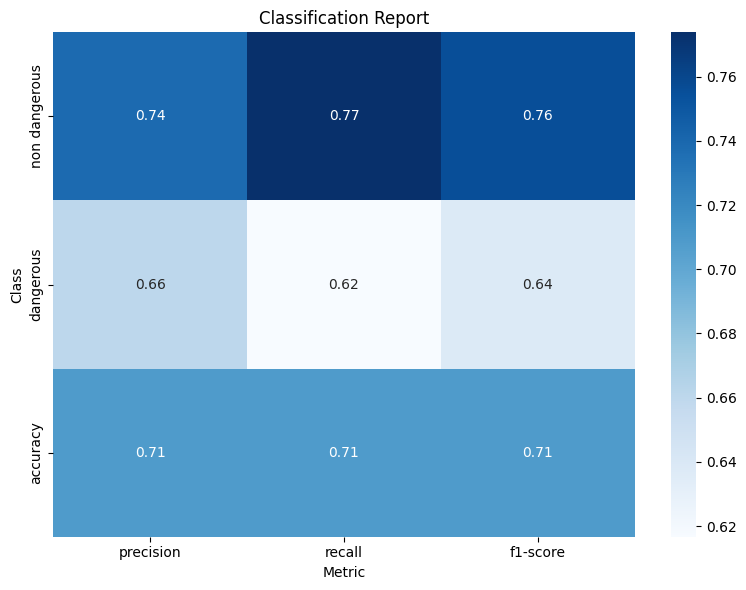

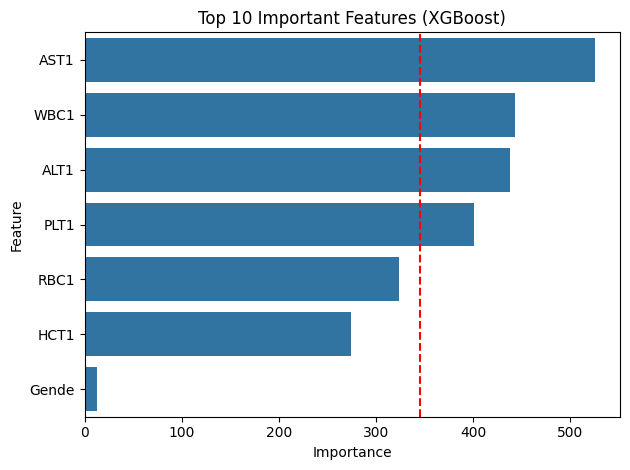

In [197]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=17, stratify=Y)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    # use_label_encoder=False,
    eval_metric='error'
)

xgb_model.fit(x_train, y_train)
evaluate(xgb_model, x_test, y_test)
gain_importances_df = plot_feature_importance(xgb_model, features, importance_type='total_gain')

### LightGBM

In [198]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4, 5, -1],  # -1 means no limit
    'min_child_samples': [5, 10, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

random_search = RandomizedSearchCV(
    lgb.LGBMClassifier(random_state=42, verbose=-1), # type: ignore
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1_weighted',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit random search
random_search.fit(x_train, y_train)

/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/smivys/Sorbonne/108/m2_internship/108-env/lib/python3.12/site-packages/sklearn/utils/v

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42, verbose=-1),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [2, 3, 4, 5, -1],
                                        'min_child_samples': [5, 10, 20, 50],
                                        'n_estimators': [50, 100, 200],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0, 0.1, 0.5, 1],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1_weighted')

In [199]:
# Get best parameters
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Train final model with best parameters
best_lgb_model = lgb.LGBMClassifier(**random_search.best_params_, random_state=42)
best_lgb_model.fit(x_train, y_train)

Best Parameters: {'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_samples': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best Score: 0.6825581345808319


LGBMClassifier(colsample_bytree=0.6, max_depth=3, min_child_samples=5,
               random_state=42, reg_alpha=0.1, reg_lambda=0, subsample=0.6)